## Imports

In [5]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
import math

## Collect the data

In [6]:
root_dir = '..'
data_dir = os.path.join(root_dir, 'data')
images_dir = os.path.join(data_dir, 'Orignal-Dataset')
root_dir, data_dir, images_dir

('..', '..\\data', '..\\data\\Orignal-Dataset')

In [7]:
# Function to load all images from a folder

def load_images_from_folder(folder_path, resize=None):
    """
    Load all images from a folder
    
    Args:
        folder_path: path to the folder
        resize: tuple (width, height) to resize images, None to skip resizing
    
    Returns:
        list: list of tuples (image, filename)
    """
    images = []
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist")
        return images
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            filepath = os.path.join(folder_path, filename)
            try:
                # Use PIL to load image and convert to numpy array (BGR format for OpenCV compatibility)
                img = Image.open(filepath).convert('RGB')
                img_array = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
                
                if resize:
                    img_array = cv2.resize(img_array, resize)
                images.append((img_array, filename))
            except Exception as e:
                print(f"Failed to load {filename}: {e}")
    
    return images

# Load images from Orignal-Dataset
soil_types = ['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 
              'Mountain_Soil', 'Red_Soil', 'Yellow_Soil']

images_dict = {}
for soil_type in soil_types:
    folder_path = os.path.join(data_dir, 'Orignal-Dataset', soil_type)
    images_dict[soil_type] = load_images_from_folder(folder_path)
    print(f"{soil_type}: {len(images_dict[soil_type])} images loaded")

Alluvial_Soil: 51 images loaded
Arid_Soil: 284 images loaded
Black_Soil: 255 images loaded
Laterite_Soil: 219 images loaded
Mountain_Soil: 201 images loaded
Red_Soil: 109 images loaded
Yellow_Soil: 69 images loaded


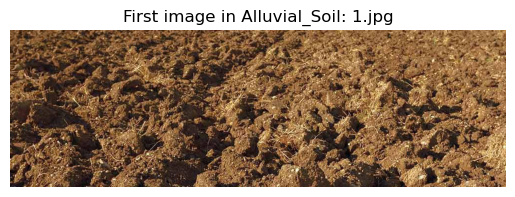

In [8]:
# Display the first image 

first_soil_type = soil_types[0]
if images_dict[first_soil_type]:
    first_image, first_filename = images_dict[first_soil_type][0]
    plt.imshow(cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB))
    plt.title(f"First image in {first_soil_type}: {first_filename}")
    plt.axis('off')
    plt.show()

## Pre-process the data

In [9]:
# Standardize the data

def standardize_image(image):
    """
    Standardize an image to have zero mean and unit variance per channel.
    
    Args:
        image: numpy array of shape (H, W, C)

    Returns:
        standardized_image: numpy array of same shape as input
    """
    standardized_image = np.zeros_like(image, dtype=np.float32)
    for c in range(image.shape[2]):
        channel = image[:, :, c]
        mean = np.mean(channel)
        std = np.std(channel)
        if std > 0:
            standardized_image[:, :, c] = (channel - mean) / std
        else:
            standardized_image[:, :, c] = channel - mean  # Avoid division by zero
    return standardized_image

# Standardize all images in the dataset
standardized_images_dict = {}
for soil_type, images in images_dict.items():
    standardized_images = []
    for img, filename in images:
        standardized_img = standardize_image(img)
        standardized_images.append((standardized_img, filename))
    standardized_images_dict[soil_type] = standardized_images

## Build the GAN model

In [10]:
# Generator

class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape): # img_shape is a tuple (C, H, W)
        super(Generator, self).__init__() # Initialize the Generator class
        self.latent_dim = latent_dim  # Dimensionality of the latent space
        self.img_shape = img_shape    # Shape of the output image
        
        def block(in_feat, out_feat, normalize=True):   # Define a block of layers
            layers = [nn.Linear(in_feat, out_feat)]  # Linear layer
            if normalize:   # Add batch normalization if specified
                layers.append(nn.BatchNorm1d(out_feat, 0.8))   # Batch normalization layer
            layers.append(nn.LeakyReLU(0.2, inplace=True))     # LeakyReLU activation
            return layers   # Return the list of layers
        
        self.model = nn.Sequential(   # Define the model as a sequence of layers
            *block(latent_dim, 128, normalize=False),  # First block without normalization
            *block(128, 256),  # Second block
            *block(256, 512),  # Third block
            *block(512, 1024), # Fourth block
            nn.Linear(1024, int(np.prod(img_shape))),  # Final linear layer to match image size
            nn.Tanh()  # Tanh activation to output values in [-1, 1]
        )
    
    def forward(self, z):   # Define the forward pass
        img = self.model(z)  # Pass the input through the model
        img = img.view(img.size(0), *self.img_shape)  # Reshape output to image shape
        return img  # Return the generated image

In [11]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self, img_shape):  # img_shape is a tuple (C, H, W)
        super(Discriminator, self).__init__()  # Initialize the Discriminator class
        self.img_shape = img_shape  # Shape of the input image
        
        self.model = nn.Sequential(  # Define the model as a sequence of layers
            nn.Linear(int(np.prod(img_shape)), 512),  # First linear layer
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation
            nn.Linear(512, 256),  # Second linear layer
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation
            nn.Linear(256, 1),  # Final linear layer to output a single value
            nn.Sigmoid()  # Sigmoid activation to output probability in [0, 1]
        )
    
    def forward(self, img):  # Define the forward pass
        img_flat = img.view(img.size(0), -1)  # Flatten the input image
        validity = self.model(img_flat)  # Pass the flattened image through the model
        return validity  # Return the validity score

## Train the GAN model

In [12]:
# Create train set, test set and validation set

def split_dataset(images_dict, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    Split the dataset into training, validation, and test sets.
    
    Args:
        images_dict: dictionary with soil types as keys and lists of (image, filename) tuples as values
        train_ratio: proportion of data to use for training
        val_ratio: proportion of data to use for validation
        test_ratio: proportion of data to use for testing
    Returns:
        train_set, val_set, test_set: dictionaries with the same structure as images_dict
    """
    train_set = {}
    val_set = {}
    test_set = {}
    
    for soil_type, images in images_dict.items():
        np.random.shuffle(images)  # Shuffle images to ensure randomness
        total_images = len(images)
        train_end = int(total_images * train_ratio)
        val_end = train_end + int(total_images * val_ratio)
        
        train_set[soil_type] = images[:train_end]
        val_set[soil_type] = images[train_end:val_end]
        test_set[soil_type] = images[val_end:]
    
    return train_set, val_set, test_set

train_set, val_set, test_set = split_dataset(standardized_images_dict)

In [19]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False
)

In [20]:
# Create a custom Dataset class for PyTorch

from torch.utils.data import Dataset

class SoilDataset(Dataset):
    def __init__(self, images_dict):
        """
        Args:
            images_dict: dictionary with soil types as keys and lists of (image, filename) tuples
        """
        self.data = []
        self.labels = []
        
        # Create a mapping from soil type to index
        self.soil_type_to_idx = {soil_type: idx for idx, soil_type in enumerate(images_dict.keys())}
        
        # Flatten the dictionary into lists
        for soil_type, images in images_dict.items():
            label = self.soil_type_to_idx[soil_type]
            for img, filename in images:
                self.data.append(img)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Convert image from (H, W, C) to (C, H, W) for PyTorch
        img = self.data[idx]
        img = np.transpose(img, (2, 0, 1))  # Convert to (C, H, W)
        img_tensor = torch.FloatTensor(img)
        label = self.labels[idx]
        return img_tensor, label

# Create datasets
train_dataset = SoilDataset(train_set)
val_dataset = SoilDataset(val_set)
test_dataset = SoilDataset(test_set)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 828
Validation set size: 115
Test set size: 245


In [21]:
lr = 0.001
num_epochs = 100
loss_function = nn.BCELoss()

In [22]:
# Instantiate the models
latent_dim = 100  # Dimension of the latent space
img_shape = (3, 224, 224)  # Shape of images (C, H, W) - adjust according to your standardized images

generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

# Select Adam optimizer for both generator and discriminator
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [23]:
# Training loop (skeleton)

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_discriminator.zero_grad()

        # Real images
        real_imgs = imgs.float()
        real_loss = loss_function(discriminator(real_imgs), valid)

        # Fake images
        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        fake_loss = loss_function(discriminator(gen_imgs.detach()), fake)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_discriminator.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_generator.zero_grad()

        # Generate a batch of images
        gen_imgs = generator(z)
        g_loss = loss_function(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_generator.step()

    print(f"[Epoch {epoch}/{num_epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

KeyError: 1